# 07. 生成モデル

本章では生成モデルの代表例であるオートエンコーダーを実装する。

datasetはMNISTで、0～9の手書き数字の画像がラベルと一緒に格納されている。これを学習用と検証用に分けて利用する。

所要時間：<font color="Red">3~5時間</font>

### 【Google colabのみ実行】ライブラリのインストール

必要なライブラリのインストールと、実行環境のバージョンを統一します。<br>

使用するライブラリ名とバージョンは配布資料の<font color=Red>「requirements.txt」</font>で確認できます。

※以下のセルを実行しましたら、「ランタイム」→「ランタイムを再起動」により<font color=Red>再起動</font>を行ってください。

In [ ]:
import sys
# Google colab環境であるか判定
if 'google.colab' in sys.modules:
    # ライブラリのインストール
    !pip install torch==1.13.0 torchvision==0.14.0
else:
    print("Not Google Colab")

## ライブラリのインポート

In [1]:
%matplotlib inline

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import scipy
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

rng = np.random.RandomState(1234)
random_state = 42

## データセットの用意

データセットはpytorchに含まれているため、簡単に呼び出してローカルに保存できる。

さらに前処理はComposeでひとまとめにする。「ToTensor」はデータセットをテンソル化する関数，「Lambda」は「view(-1)」を表す自作関数で，データセットを一次元配列化する役割を担っている。

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)),
])

batch_size = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_epochs = 15

dataloader_train = torch.utils.data.DataLoader(
    datasets.MNIST(root='./data', train=True, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=False
)

dataloader_test = torch.utils.data.DataLoader(
    datasets.MNIST(root='./data', train=False, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=False
)

データを確認して順番に5つ表示してみよう。

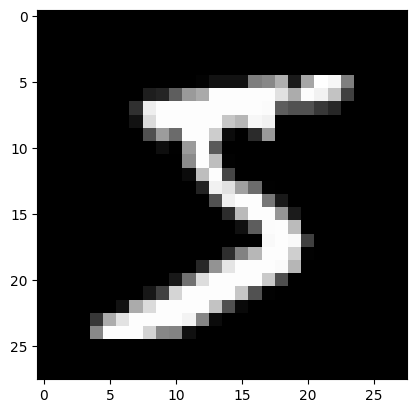

label:  tensor(5)


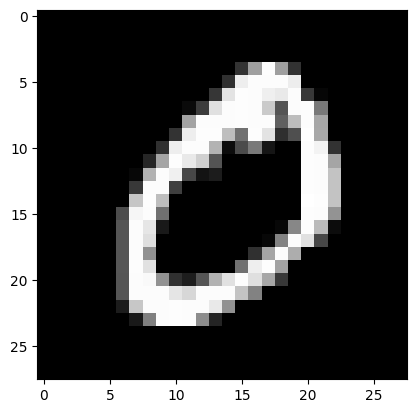

label:  tensor(0)


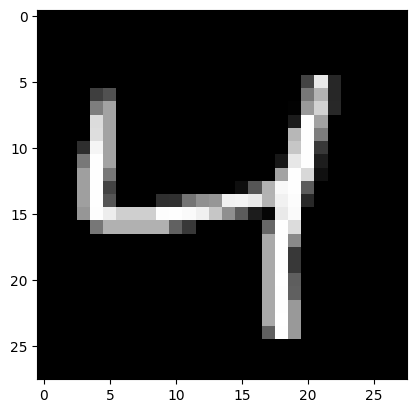

label:  tensor(4)


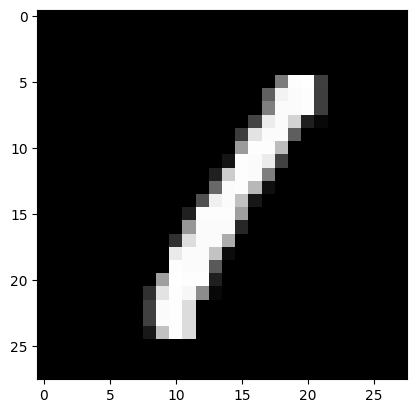

label:  tensor(1)


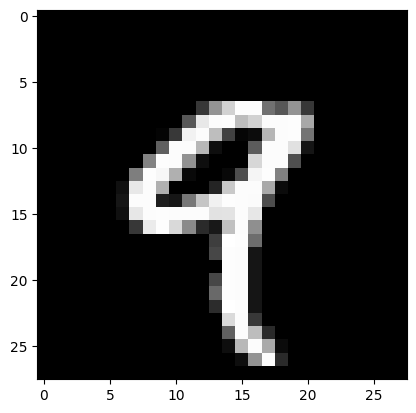

label:  tensor(9)


In [3]:
# データの確認
batch_train = next(iter(dataloader_train))

# データを5つ表示
for i in range(5):
    plt.gray()
    plt.imshow(batch_train[0][i].reshape((28,28)))
    plt.show()
    print("label: ", batch_train[1][i])

## AEによるMNISTの画像生成（PyTorch）

オートエンコーダーは、エンコーダーで元の画像を低次元の特徴量に圧縮して、デコーダーで低次元の特徴量から元の画像を復元させるようなネットワークである。



#### AE(Auto Encoder)について

AEとはエンコーダーとデコーダーの2つのニューラルネットワークを結合したモデルで、データの圧縮や異常検知に使われる。

#### AEの基本的な構造

Encoder-Decoderモデルでは、<font color="Green">Encoder</font>により潜在変数に落とし込み（情報を圧縮し）、<font color="Blue">Decoder</font>により潜在変数からデータ生成を行います。

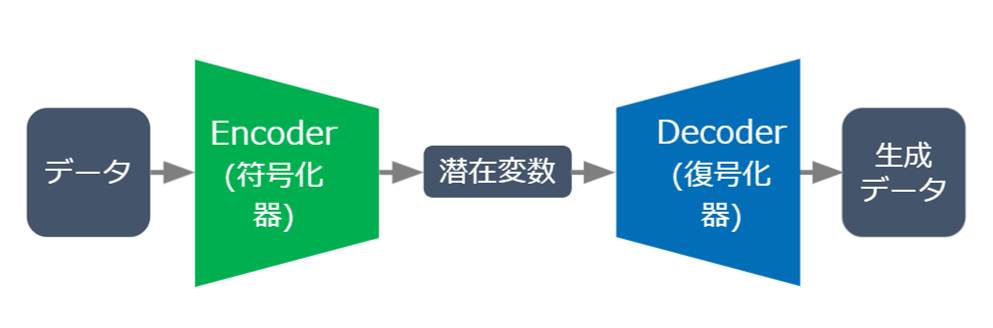

今回実装するモデルの構造は
```
Encoder: 512次元→64次元→32次元→10次元
Decoder: 10次元→32次元→64次元→512次元
```
とします。



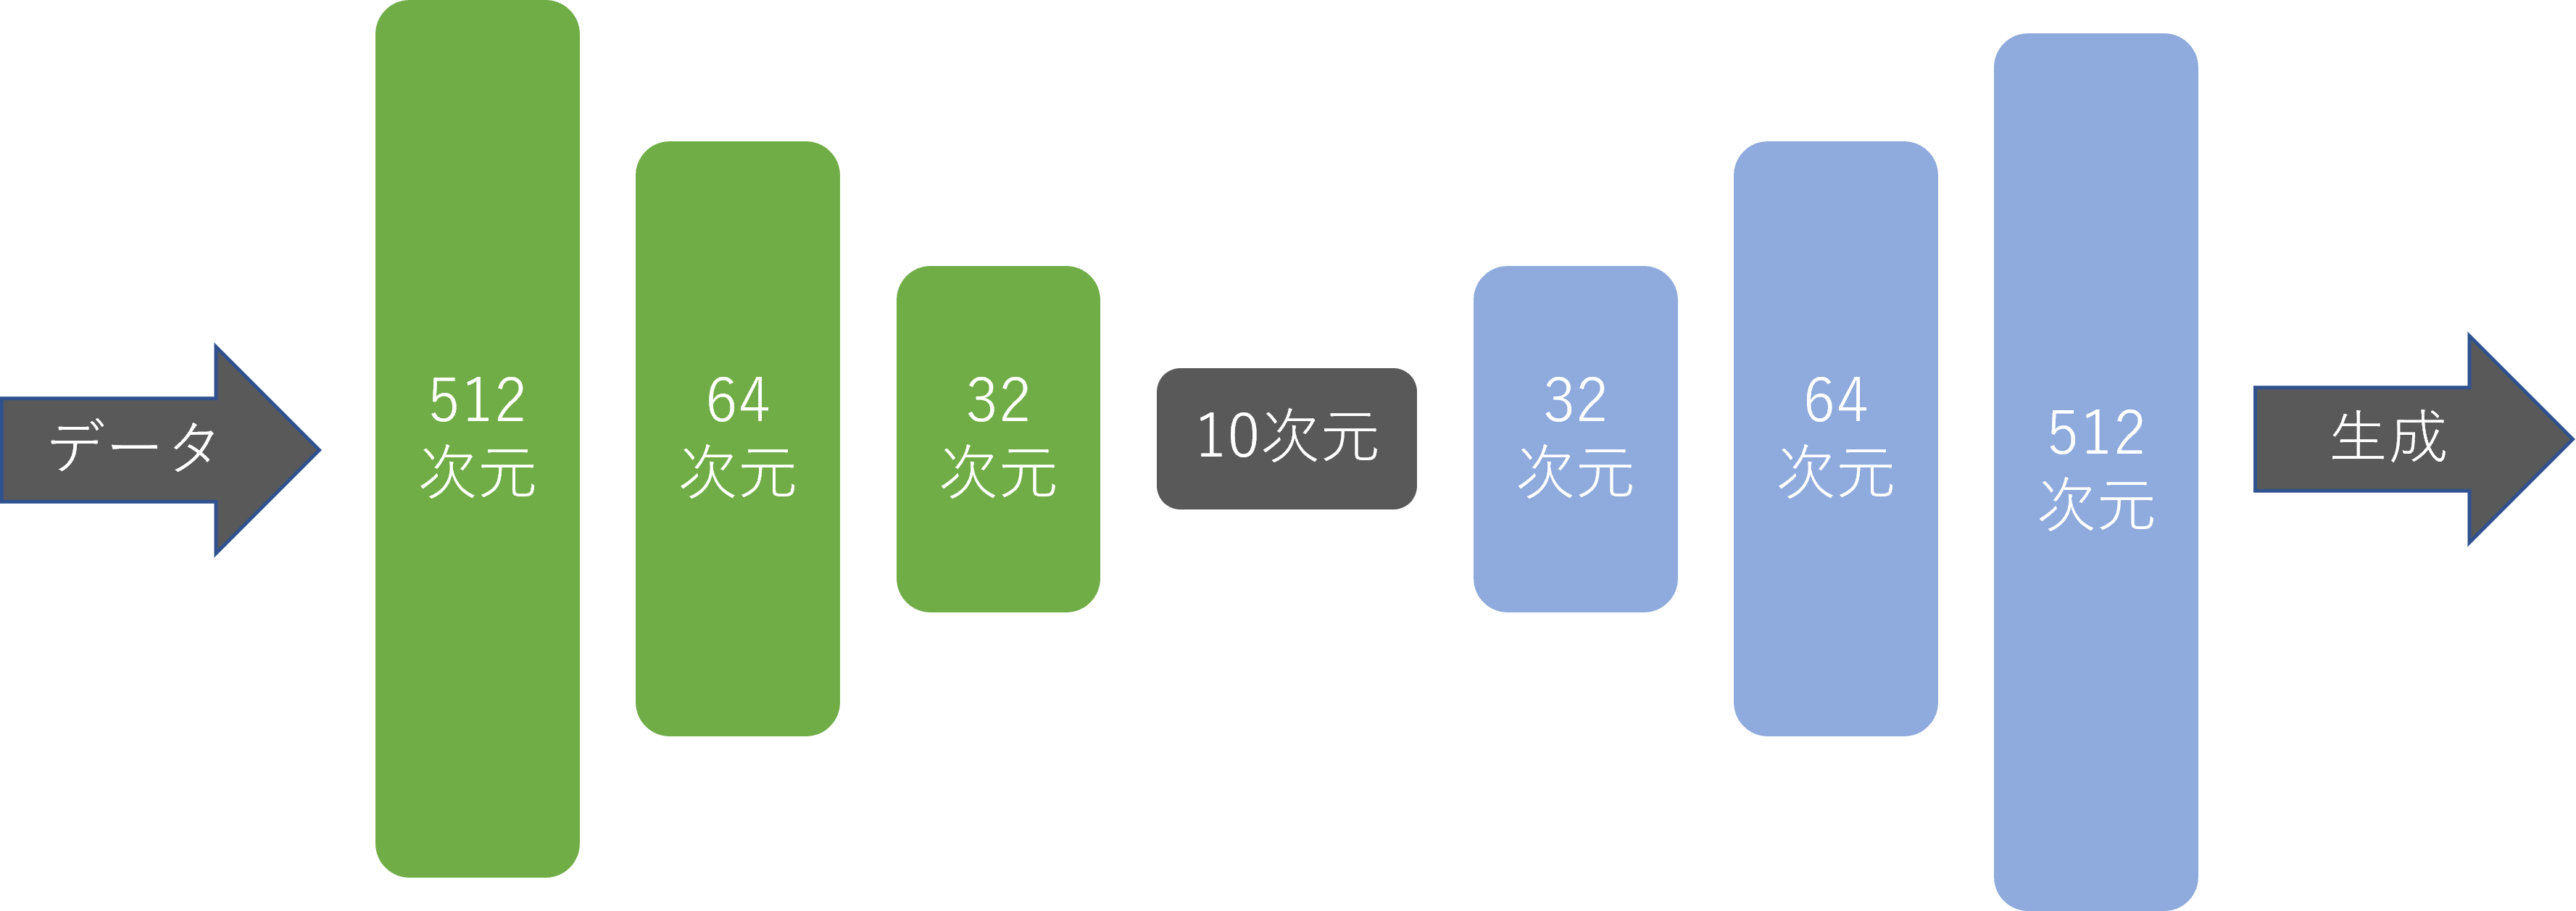

* <font color="Red">問1-1. 【イニシャライザ】第1層ではデータを512次元に圧縮する。データセットの次元を求めて、nn.Linearの引数に入力しよう。</font><br>
* <font color="Red">問1-2. 【イニシャライザ】最終層では512次元のデータを元の次元に復元する。データセットの次元を求めて、nn.Linearの引数に入力しよう。</font><br>
* <font color="Red">問1-3. 【encoder関数】エンコーダーでは活性化関数ReLUを介してデータxを各層に読み込ませていく。**self.dense_enc〇**(〇は1～4の数字)を引数として、encoderの層別構造を記述しよう。なお、encoderの4層目は出力になるため活性化関数は不要である。</font><br>        
* <font color="Red">問1-4. 【decoder関数】問1-3と同様の手順で、decoderの層別構造を記述しよう。(デコーダーでは最後にsigmoid関数に通します。）</font><br>

#### AEの損失関数

`reconstruction loss`は入力画像をどれだけ正確に復元できたかを表す損失値です。

交差エントロピー誤差を適応します。

$$
\rm{reconstruction~loss} = \frac{1}{N}\sum^N\sum^C\{{-x\log{y}-(1-x)\log(1-y)}\}
$$

```
【関数の説明】
  nn.Linear(input_dim, output_dim): 全結合層を実装できる関数です。入力データの次元と出力データの次元をそれぞれ`input_dim`, `output_dim`で指定します。
  F.relu(input): テンソルinputに対するReLU関数の出力を返します。
  torch.sigmoid(input): テンソルinputに対するシグモイド関数の出力を返します。
  torch.mean(input, dim): テンソルinputの次元dimに対して平均値を返します。
  torch.sum(input, dim): テンソルinputの次元dimに対して合計値を返します。
```

* <font color="Red">問1-5. 【loss関数】入力 x と出力 y から、損失関数reconstraction lossの値を算出しよう。

In [4]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.dense_enc1 = nn.Linear(28*28, 512) ### 問1-1 ###
        self.dense_enc2 = nn.Linear(512, 64)
        self.dense_enc3 = nn.Linear(64, 32)
        self.dense_enc4 = nn.Linear(32, 10)
        self.dense_dec1 = nn.Linear(10, 32)
        self.dense_dec2 = nn.Linear(32, 64)
        self.dense_dec3 = nn.Linear(64, 512)
        self.dense_dec4 = nn.Linear(512, 28*28) ### 問1-2 ###

    def _encoder(self, x): 
        x = F.relu(self.dense_enc1(x))
        x = F.relu(self.dense_enc2(x))
        x = F.relu(self.dense_enc3(x)) ### 問1-3 ###
        x = self.dense_enc4(x)
        return x

    def _decoder(self, x):
        x = F.relu(self.dense_dec1(x))
        x = F.relu(self.dense_dec2(x))
        x = F.relu(self.dense_dec3(x)) ### 問1-4 ###
        x = torch.sigmoid(self.dense_dec4(x))
        return x

    def forward(self, x):
        x = self._encoder(x)
        x = self._decoder(x)
        return x

    def loss(self, x):
        y = self._encoder(x)
        y = self._decoder(y)

        # reconstruction lossの計算
        reconstruction = torch.mean(torch.sum(-x * self.torch_log(y) - (1 - x) * self.torch_log(1 - y), dim=1)) ### 問1-5 ###

        return reconstruction 
    
    # torch.log(0)によるnanを防ぐ
    def torch_log(self, x):
        return torch.log(torch.clamp(x, min=1e-10))

### 学習と評価

学習を進めていくと、次第にtest用データに対する損失がreconstraction_lossに近づいていく様子が分かる。

In [5]:
AE_model = AE().to(device)
optimizer = optim.Adam(AE_model.parameters(), lr=0.001)
for epoch in range(n_epochs):
    losses = []
    reconstruction_losses = []
    AE_model.train()
    for x, _ in dataloader_train:

        x = x.to(device)

        AE_model.zero_grad()
        reconstruction_loss = AE_model.loss(x)
        
        loss = reconstruction_loss
        
        loss.backward()
        optimizer.step()

        losses.append(loss.cpu().detach().numpy())
        reconstruction_losses.append(reconstruction_loss.cpu().detach().numpy())

    losses_test = []
    AE_model.eval()
    for x, t in dataloader_test:

        x = x.to(device)

        reconstruction_loss = AE_model.loss(x)

        loss = reconstruction_loss

        losses_test.append(loss.cpu().detach().numpy())

    print('EPOCH:%d, Train Lower Bound:%lf, (%lf), Test Lower Bound:%lf' %
          (epoch+1, np.average(losses), np.average(reconstruction_losses), np.average(losses_test)))

EPOCH:1, Train Lower Bound:181.949844, (181.949844), Test Lower Bound:140.549957
EPOCH:2, Train Lower Bound:124.457588, (124.457588), Test Lower Bound:118.306610
EPOCH:3, Train Lower Bound:112.539322, (112.539322), Test Lower Bound:110.609856
EPOCH:4, Train Lower Bound:105.408371, (105.408371), Test Lower Bound:104.138947
EPOCH:5, Train Lower Bound:100.713867, (100.713867), Test Lower Bound:101.583809
EPOCH:6, Train Lower Bound:98.035492, (98.035492), Test Lower Bound:99.873283
EPOCH:7, Train Lower Bound:95.574661, (95.574661), Test Lower Bound:97.305412
EPOCH:8, Train Lower Bound:93.433060, (93.433060), Test Lower Bound:95.231316
EPOCH:9, Train Lower Bound:91.861000, (91.861000), Test Lower Bound:93.744484
EPOCH:10, Train Lower Bound:90.545952, (90.545952), Test Lower Bound:92.379730
EPOCH:11, Train Lower Bound:89.107384, (89.107384), Test Lower Bound:90.922218
EPOCH:12, Train Lower Bound:87.517029, (87.517029), Test Lower Bound:89.323143
EPOCH:13, Train Lower Bound:86.028084, (86.028

### 元画像と復元画像の比較

テスト用データの画像を入力として、AEで再構成した画像と比較してみよう。

まずはオリジナルのテスト用データの画像を表示する。

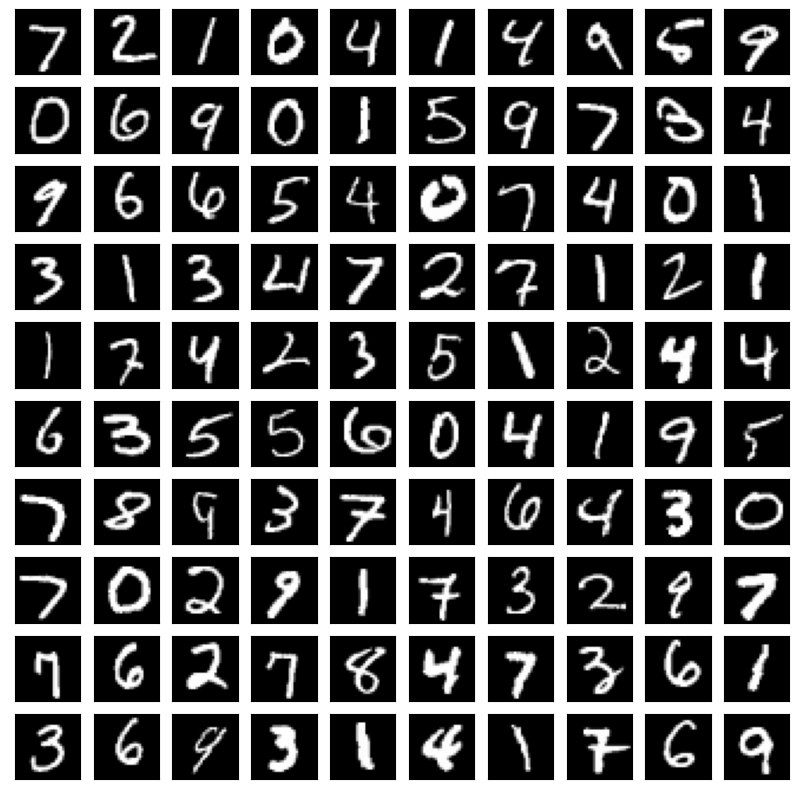

In [6]:
# オリジナルのMNISTイメージ
valid_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
fig = plt.figure(figsize=(10, 10))
for i in range(100):
    x, t = valid_dataset[i]
    im = x.view(-1, 28, 28).permute(1, 2, 0).squeeze().numpy()
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

次に、AEで再構成した画像を表示する。

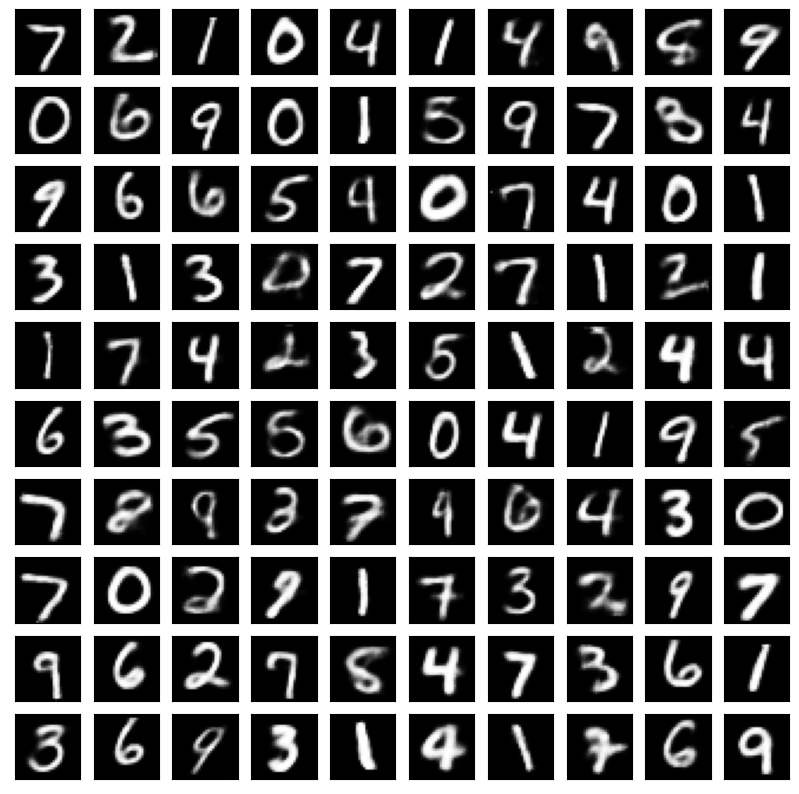

In [7]:
# AEで再構成したMNISTイメージ
valid_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
fig = plt.figure(figsize=(10, 10))
AE_model.eval()
for i in range(100):
    x, t = valid_dataset[i]
    x = x.to(device)
    x = x.unsqueeze(0)
    y = AE_model(x)
    im = y.view(-1, 28, 28).permute(1, 2, 0).cpu().squeeze().detach().numpy()
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

## VAEによるMNISTの画像生成（PyTorch） 
#### VAEとは

エンコーダの目的はデータ分布を生成することです。

AEはもともと存在するデータを忠実に再現しようとします。しかし、忠実に再現しようとした結果、「遊び」がなく、連続性の高いデータ分布を生成することが出来ません。

そこでVAE(Variational Autoencoder)では、入力データを圧縮して得られる潜在変数を確率変数として表します。さらに潜在変数をガウス分布からサンプリングする制約を設けることでデータの潜在空間上での分布に連続性を持たせることが出来ます。

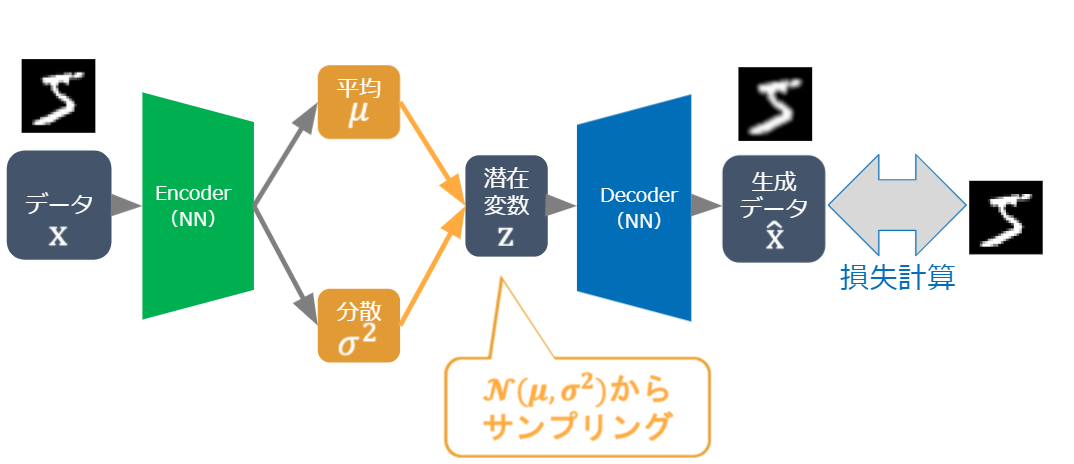

#### VAEのアルゴリズム



1. <font color='Green'>Encoder</font>により、データから$x$から潜在変数$z$の分布の平均$\mu$と分散$\sigma^2$を出力する。分散については負の数にならないよう、softplus関数を最後に適用する。<br>
2. 出力された平均$\mu$と分散$\sigma^2$のガウス分布に従う潜在変数$z$をサンプリングする。<br>
3. <font color='Blue'>Decoder</font>により、潜在変数$z$から新たなデータ$\hat{x}$を生成する。<br>
4. 以下の損失関数により損失計算

$$
\rm{reconstruction~loss} = \frac{1}{N}\sum^N\sum^C\{{-x\log{y}-(1-x)\log(1-y)}\}
$$
$$
\rm{KL} =  - \frac{1}{2N}\sum^N\sum^C{(1+log\sigma^2-\mu^2-\sigma^2)}
$$
$$
\rm{loss} = \rm{reconstruction~loss} + \rm{KL}
$$

* <font color="Red">問2-1,2-2. 【encoder関数】平均，分散の算出式を記述してください。</font><br>
* <font color="Red">問2-3. 【sampling関数】ガウス分布を算出する関数を完成させてください。</font><br>
【ヒント】
ガウス分布からランダムに抽出された値を$\epsilon$とすると、ガウス分布に従う潜在変数$z$は以下のように算出されます。
$$
\epsilon = \frac{z-\mu}{\sigma}~~~~~\Longrightarrow~~~~~z=\mu+\sigma\epsilon
$$


#### VAEの損失関数

KLダイバージェンスを使った損失は以下のように算出されます。

$$
\rm{KL} =  - \frac{1}{2N}\sum^N\sum^C{(1+log\sigma^2-\mu^2-\sigma^2)}
$$

* <font color="Red">問2-4. 【loss関数】KL_lossの算出を記述してください。</font><br>

In [8]:
class VAE(nn.Module):
    def __init__(self, z_dim):
        super(VAE, self).__init__()
        self.dense_enc1 = nn.Linear(28*28, 200)
        self.dense_enc2 = nn.Linear(200, 200)
        self.dense_encmean = nn.Linear(200, z_dim)
        self.dense_encvar = nn.Linear(200, z_dim)
        self.dense_dec1 = nn.Linear(z_dim, 200)
        self.dense_dec2 = nn.Linear(200, 200)
        self.dense_dec3 = nn.Linear(200, 28*28)

    def _encoder(self, x):
        x = F.relu(self.dense_enc1(x))
        x = F.relu(self.dense_enc2(x))
        mean = self.dense_encmean(x) ### 問2-1 ###
        var = F.softplus(self.dense_encvar(x)) ### 問2-2 ###
        return mean, var

    def _sample_z(self, mean, var):
        epsilon = torch.randn(mean.shape, device=device)
        return mean + torch.sqrt(var) * epsilon ### 問2-3 ###

    def _decoder(self, z):
        x = F.relu(self.dense_dec1(z))
        x = F.relu(self.dense_dec2(x))
        x = torch.sigmoid(self.dense_dec3(x))
        return x

    def forward(self, x):
        mean, var = self._encoder(x)
        z = self._sample_z(mean, var)
        x = self._decoder(z)
        return x, z

    def loss(self, x):
        mean, var = self._encoder(x)
        # KL lossの計算
        KL = -0.5 * torch.mean(torch.sum(1 + self.torch_log(var) - mean**2 - var, dim=1)) ### 問2-4 ###

        z = self._sample_z(mean, var)
        y = self._decoder(z)

        # reconstruction lossの計算
        reconstruction = torch.mean(torch.sum(-x * self.torch_log(y) - (1 - x) * self.torch_log(1 - y), dim=1))

        return KL, reconstruction 
    
    # torch.log(0)によるnanを防ぐ
    def torch_log(self, x):
        return torch.log(torch.clamp(x, min=1e-10))

### 学習と評価

In [9]:
z_dim = 2#10
VAE_model = VAE(z_dim).to(device)
optimizer = optim.Adam(VAE_model.parameters(), lr=0.001)
for epoch in range(n_epochs):
    losses = []
    KL_losses = []
    reconstruction_losses = []
    VAE_model.train()
    for x, _ in dataloader_train:

        x = x.to(device)

        VAE_model.zero_grad()
        KL_loss, reconstruction_loss = VAE_model.loss(x)  # lossの各項の計算

        loss = KL_loss + reconstruction_loss  # 和を取ってlossとする

        loss.backward()
        optimizer.step()

        losses.append(loss.cpu().detach().numpy())
        KL_losses.append(KL_loss.cpu().detach().numpy())
        reconstruction_losses.append(reconstruction_loss.cpu().detach().numpy())

    losses_test = []
    VAE_model.eval()
    for x, t in dataloader_test:

        x = x.to(device)

        KL_loss, reconstruction_loss = VAE_model.loss(x)

        loss = KL_loss + reconstruction_loss

        losses_test.append(loss.cpu().detach().numpy())

    print('EPOCH:%d, Train Lower Bound:%lf, (%lf, %lf), Test Lower Bound:%lf' %
          (epoch+1, np.average(losses), np.average(KL_losses), np.average(reconstruction_losses), np.average(losses_test)))

EPOCH:1, Train Lower Bound:190.273941, (3.652828, 186.621124), Test Lower Bound:173.765137
EPOCH:2, Train Lower Bound:165.310684, (4.929411, 160.381271), Test Lower Bound:166.397720
EPOCH:3, Train Lower Bound:158.976013, (5.380840, 153.595184), Test Lower Bound:159.903336
EPOCH:4, Train Lower Bound:155.006454, (5.644345, 149.362106), Test Lower Bound:155.229691
EPOCH:5, Train Lower Bound:152.097687, (5.812387, 146.285294), Test Lower Bound:152.965073
EPOCH:6, Train Lower Bound:149.902847, (5.984475, 143.918381), Test Lower Bound:150.800354
EPOCH:7, Train Lower Bound:148.193253, (6.077464, 142.115784), Test Lower Bound:150.451309
EPOCH:8, Train Lower Bound:146.883148, (6.172519, 140.710632), Test Lower Bound:148.024460
EPOCH:9, Train Lower Bound:145.878128, (6.222217, 139.655914), Test Lower Bound:147.694458
EPOCH:10, Train Lower Bound:145.043777, (6.283371, 138.760422), Test Lower Bound:147.089996
EPOCH:11, Train Lower Bound:144.342636, (6.314378, 138.028259), Test Lower Bound:145.8560

### 元画像と復元画像の比較

テスト用データの画像を入力として、VAEで再構成した画像と比較してみよう。

まずはオリジナルのテスト用データの画像を表示する。

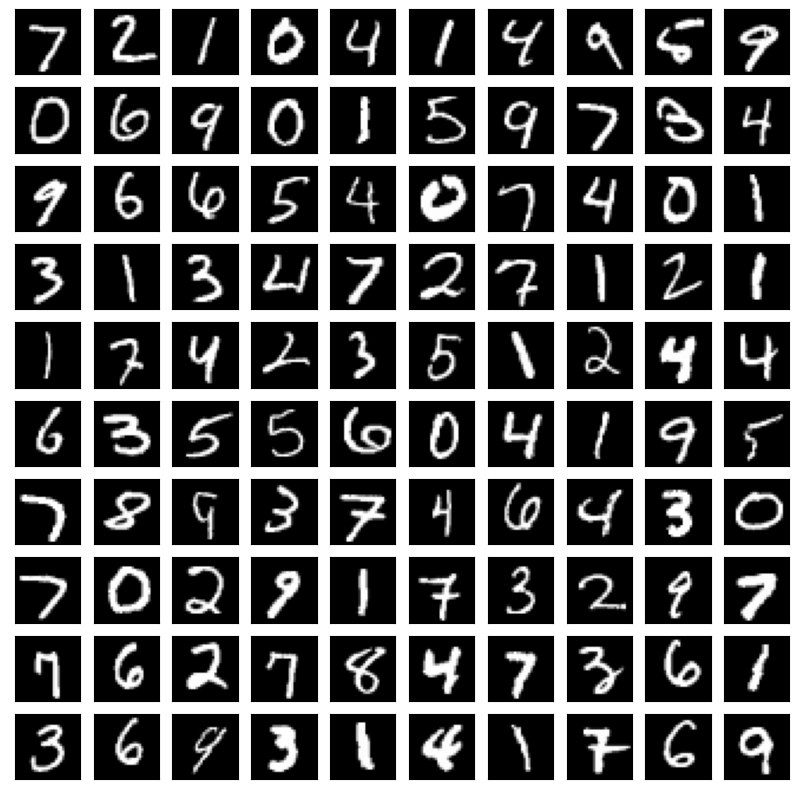

In [10]:
# オリジナルのMNISTイメージ
valid_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
fig = plt.figure(figsize=(10, 10))
for i in range(100):
    x, t = valid_dataset[i]
    x = x.to(device)
    im = x.view(-1, 28, 28).permute(1, 2, 0).squeeze().cpu().numpy()
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

次に、VAEで再構成した画像を表示する。

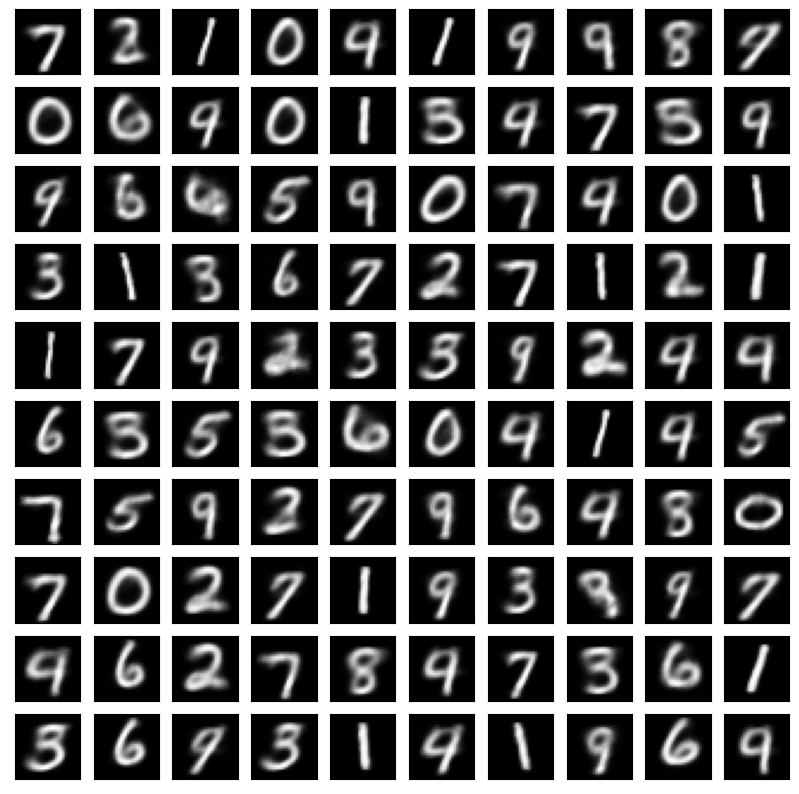

In [11]:
# VAEで再構成したMNISTイメージ
valid_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
fig = plt.figure(figsize=(10, 10))
VAE_model.eval()
for i in range(100):
    x, t = valid_dataset[i]
    x = x.to(device)
    x = x.unsqueeze(0)
    y, z = VAE_model(x)
    im = y.view(-1, 28, 28).permute(1, 2, 0).cpu().squeeze().detach().numpy()
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

潜在変数からランダムサンプリングしてイメージを生成すると、以下のようになる。

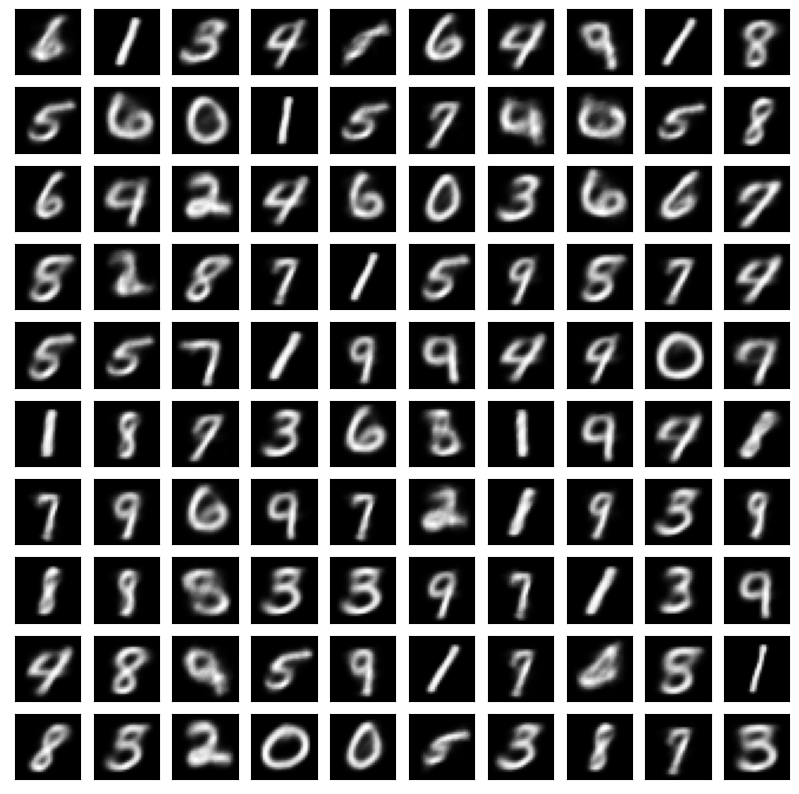

In [12]:
# 潜在変数からランダムサンプリング(潜在変数をランダムに決め, その潜在変数から生成されるMNISTイメージ)
fig = plt.figure(figsize=(10, 10))
VAE_model.eval()
for i in range(100):
    z = torch.randn([1, z_dim]).to(device)
    y = VAE_model._decoder(z)
    im = y.view(-1, 28, 28).permute(1, 2, 0).cpu().squeeze().detach().numpy()
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

最後に、潜在変数による連続的な変化を可視化してみよう。

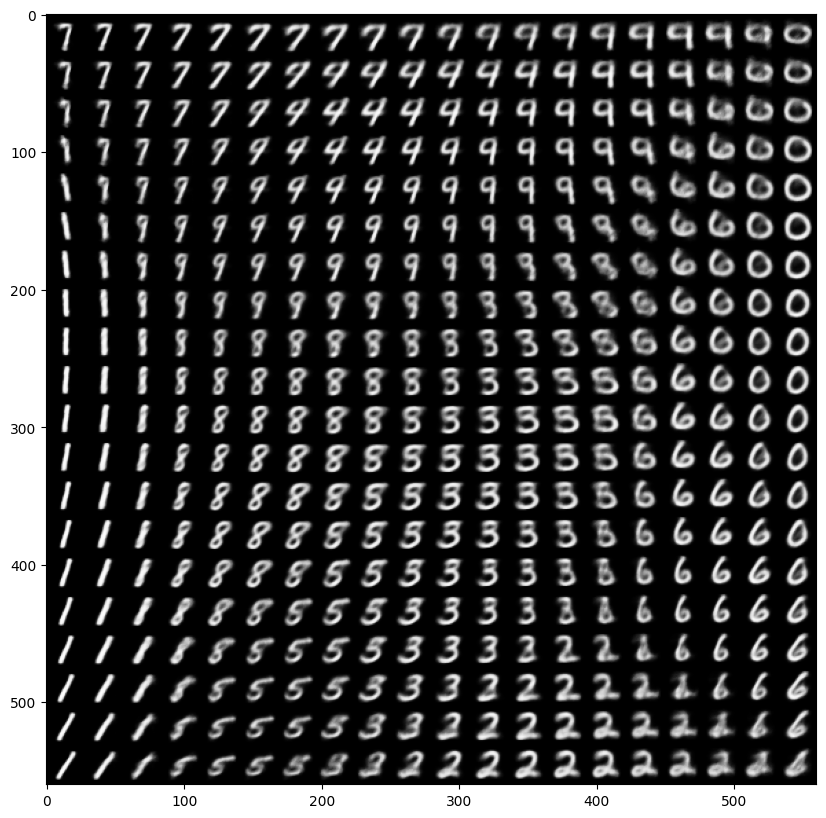

In [13]:
# 多様体の可視化
import matplotlib.pyplot as plt
from scipy.stats import norm

n = 20
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        z_sample = torch.from_numpy(z_sample.astype(np.float32)).clone().to(device)
        x_decoded = VAE_model._decoder(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit.to('cpu').detach().numpy()

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()